## Import librarys

In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import quandl
import config
from statsmodels.stats import diagnostic as md
import statsmodels.api as sm
from scipy.stats import jarque_bera
from sklearn.metrics import r2_score
from plotting import plot_regression
from tools import regress, p_value, hedge_ratio

## Import data

In [2]:
#Select data
data = 'corn'
#data = 'soybeans'

In [3]:
if data == 'corn':
    spot_p_df = quandl.get("TFGRAIN/SOYBEANS", authtoken=config.quandl_apikey) # Soybeans
elif data == 'soybeans':
    spot_p_df = quandl.get("TFGRAIN/CORN", authtoken=config.quandl_apikey) # Corn
    
spot_p_df.dropna(inplace=True)
N, _ = spot_p_df.shape

In [4]:
if data == 'corn':
    futures_p_df = quandl.get("CHRIS/CME_C1", authtoken=config.quandl_apikey)# Corn
elif data == 'soybeans':
    futures_p_df = quandl.get("CHRIS/CME_S1", authtoken=config.quandl_apikey) # Soybeans
M, W = futures_p_df.shape

In [5]:
futures_p_df = futures_p_df[spot_p_df.index[0]:] 
futures_p_df = futures_p_df[:spot_p_df.index[N-1]]
futures_p_df = futures_p_df.reindex(spot_p_df.index)
futures_p_df = futures_p_df.drop('Change', axis=1)
futures_p_df = futures_p_df.dropna()

In [6]:
spot_p_df = spot_p_df.reindex(futures_p_df.index)

In [7]:
N, V = spot_p_df.shape
N

4713

In [8]:
M, W = futures_p_df.shape
M

4713

## Descriptive statistics

In [9]:
pd.concat([futures_p_df[['Settle', 'Volume']], spot_p_df[['Cash Price']]], axis=1, sort=False).describe()

,Settle,Volume,Cash Price
count,4713.000000,4713.000000,4713.000000
mean,384.789041,86203.654572,9.269037
std,152.842047,73243.531284,3.176597
min,184.500000,0.000000,3.990000
25%,246.750000,25729.000000,6.330000
50%,363.750000,70537.000000,9.230000
75%,426.250000,133703.000000,11.420000
max,831.250000,538170.000000,17.990000


## Plots

/home/jonatan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


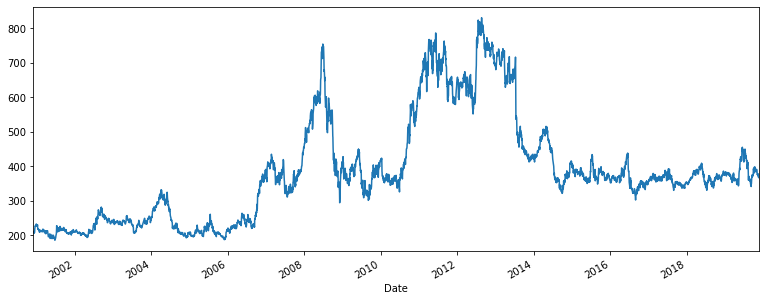

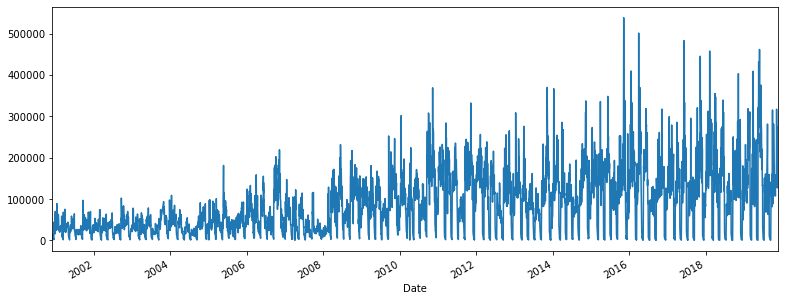

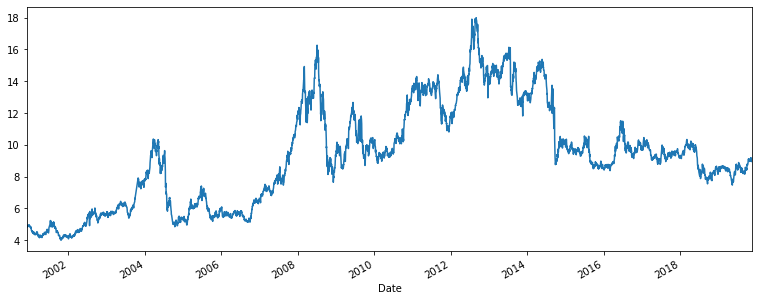

In [10]:
futures_p_df[['Settle']].plot(figsize=(13,5),legend=None)
#plt.title('Futures price')
plt.savefig(f'images/futures_price_{data}.png',bbox_inches='tight', pad_inches=0)
futures_p_df['Log Volume'] = np.log(futures_p_df[['Volume']])
futures_p_df[['Volume']].plot(figsize=(13,5),legend=None)
#plt.title('Volume')
plt.savefig(f'images/volume_{data}.png',bbox_inches='tight', pad_inches=0)
spot_p_df[['Cash Price']].plot(figsize=(13,5),legend=None)
#plt.title('Spot price')
plt.savefig(f'images/spot_price_{data}.png',bbox_inches='tight', pad_inches=0)

# Preprocess data

#### Normalize

In [11]:
norm_futures_p_df=(futures_p_df-futures_p_df.mean())/futures_p_df.std()
norm_spot_p_df=(spot_p_df-spot_p_df.mean())/spot_p_df.std()

# Constant variance

## Generalized 2

In [12]:
### Do regression and calculate residuals

In [13]:
x = np.array(list(range(M))).reshape(-1,1)
fut_data = norm_futures_p_df[['Settle', 'Volume']].values
reg_fut = LinearRegression().fit(x, fut_data)
delta_reg_fut = np.abs(fut_data - reg_fut.predict(x))
v_hat = np.linalg.norm(delta_reg_fut, axis=1)**2
v_hat = v_hat.reshape(-1,1)
fut_data.shape

(4713, 2)

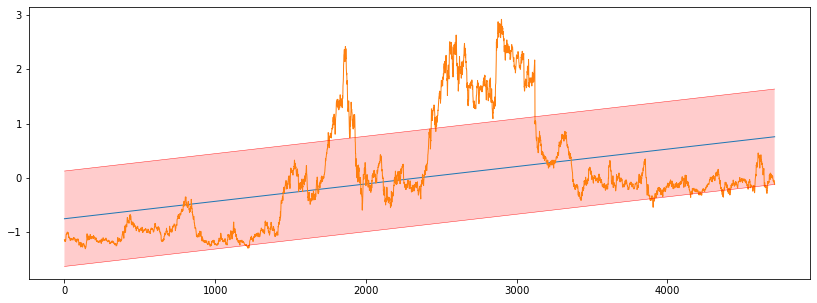

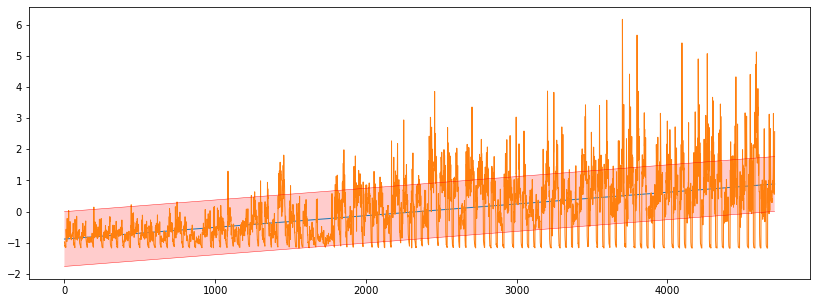

In [14]:
plot_regression(reg_fut,fut_data,f'volume_gen_2_{data}.png',True)

In [15]:
spot_data = norm_spot_p_df[['Cash Price']].values
reg_spot = LinearRegression().fit(x, spot_data)
delta_reg_spot = spot_data - reg_spot.predict(x)
u_hat = np.linalg.norm(delta_reg_spot, axis=1)**2
u_hat = u_hat.reshape(-1,1)

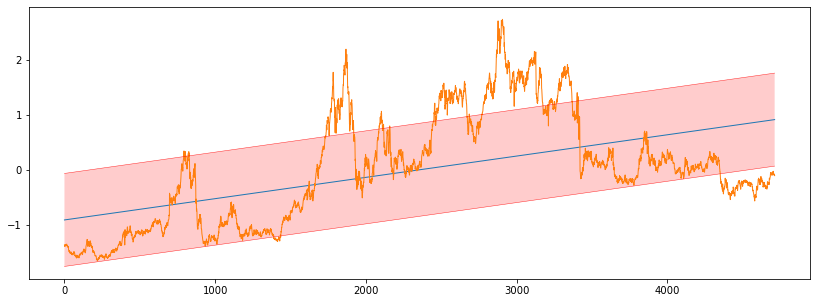

In [16]:
plot_regression(reg_spot,spot_data,f'spot_gen_1_{data}.png',True)

### Optimal hedge ratio estimator



In [17]:
r_hat = hedge_ratio(v_hat, u_hat)

In [18]:
print(f"Optimal hedge ratio = {r_hat}")

Optimal hedge ratio = [[0.3142486]]


## Price only

In [19]:
x = np.array(list(range(M))).reshape(-1,1)
fut_data = norm_futures_p_df['Settle'].values
reg_fut = LinearRegression().fit(x, fut_data)
delta = fut_data - reg_fut.predict(x)
v_hat = np.linalg.norm(delta, axis=0)**2
v_hat = v_hat.reshape(-1,1)

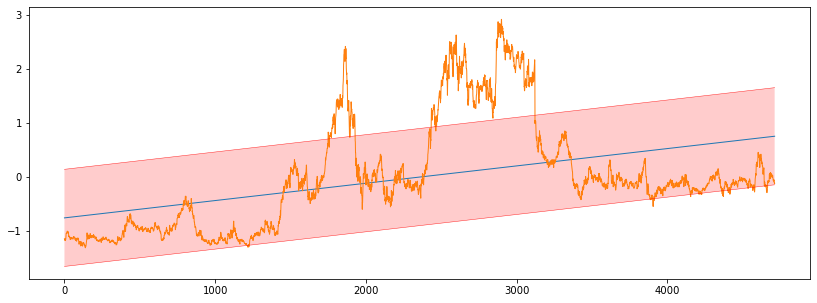

In [20]:
plot_regression(reg_fut,fut_data,f'futures_gen_1_{data}.png',True)

In [21]:
spot_data = norm_spot_p_df['Cash Price'].values
reg_spot = LinearRegression().fit(x, spot_data)
delta = spot_data - reg_spot.predict(x)
u_hat = np.linalg.norm(delta, axis=0)**2
u_hat = u_hat.reshape(-1,1)

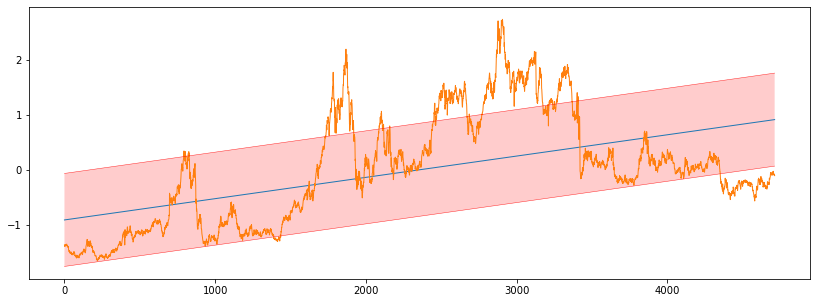

In [22]:
plot_regression(reg_spot,spot_data,f'spot_gen_1_{data}.png',True)

In [23]:
r_hat = hedge_ratio(v_hat, u_hat)
print(f"Optimal hedge ratio = {r_hat}")

Optimal hedge ratio = [[0.89012605]]



## Random walk

In [24]:
v_hat = norm_futures_p_df['Settle'].values - norm_futures_p_df['Settle'].values.mean()
v_hat = v_hat.reshape(-1,1)
u_hat = norm_spot_p_df['Cash Price'].values - norm_spot_p_df['Cash Price'].values.mean()
u_hat = u_hat.reshape(-1,1)

### Optimal hedge ratio estimator



In [25]:
r_hat = hedge_ratio(v_hat, u_hat)
print(f"Optimal hedge ratio = {r_hat}")

Optimal hedge ratio = [[0.89999946]]


## Simple

In [26]:
delta_p = (norm_futures_p_df['Settle'].values - np.concatenate(([0], norm_futures_p_df['Settle'].values))[:M])[:M-1]
delta_f = (norm_spot_p_df['Cash Price'].values - np.concatenate(([0], norm_spot_p_df['Cash Price'].values))[:M])[:M-1]

In [27]:
v_hat = delta_p - delta_p.mean()
v_hat = v_hat.reshape(-1,1)
u_hat = delta_f - delta_f.mean()
u_hat = u_hat.reshape(-1,1)

### Optimal hedge ratio estimator



In [28]:
r_hat = hedge_ratio(v_hat, u_hat)
print(f"Optimal hedge ratio = {r_hat}")

Optimal hedge ratio = [[0.55499204]]


# Moving window

In [29]:
N_predictions = 365*7

All p-values > 0.05: 0
Average R^2 = 0.48555762522404006
Average mean squared error = 1.2684851620885247
All p-values > 0.05: 0
Average R^2 = 0.5927408861937113
Average mean squared error = 1.066226447917458
Optimal hedge ratio = 1.0000521198216519


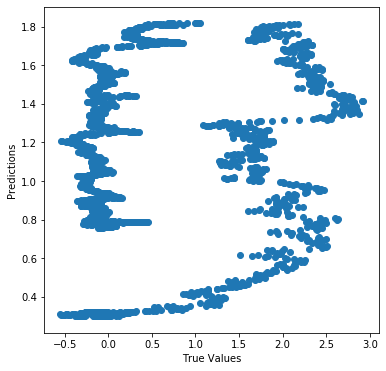

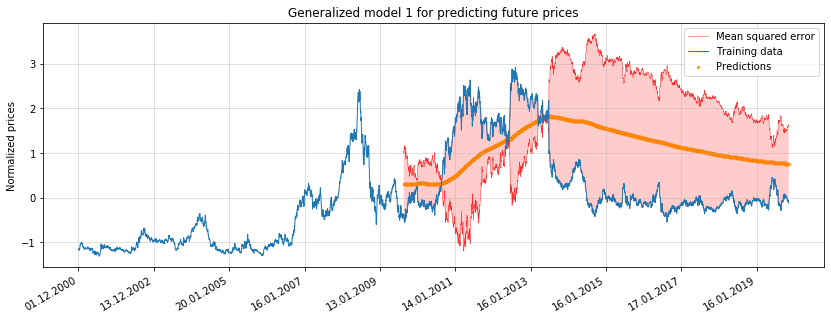

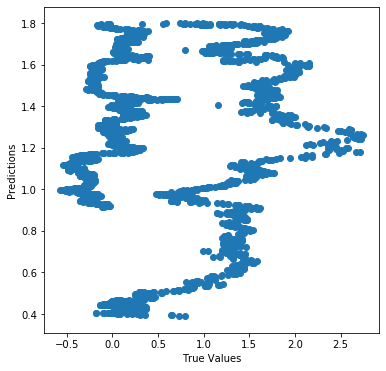

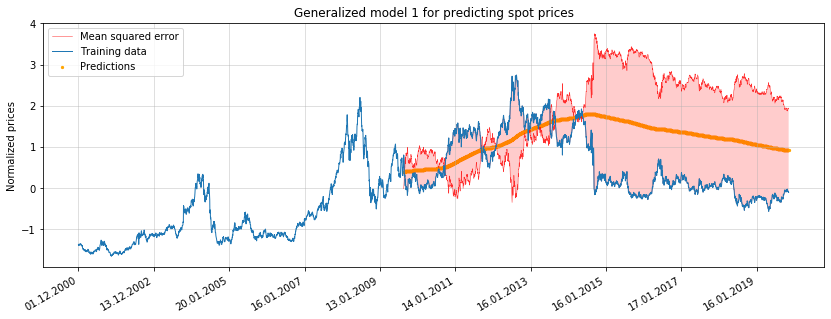

In [30]:
true_values_f, predictions_f, scores_f, mses_f = regress(x, fut_data, N_predictions, plot=True, savefig=True, name="future", plot_index=norm_futures_p_df.index)
print(f"Average R^2 = {np.mean(scores_f)}")
print(f"Average mean squared error = {np.mean(mses_f)}")
true_values_s, predictions_s, scores_s, mses_s = regress(x, spot_data, N_predictions, plot=True, savefig=True, name="spot", plot_index=norm_spot_p_df.index)
print(f"Average R^2 = {np.mean(scores_s)}")
print(f"Average mean squared error = {np.mean(mses_s)}")
u_hat = np.linalg.norm(true_values_f - predictions_f, axis=0)**2
v_hat = np.linalg.norm(true_values_s - predictions_s, axis=0)**2
print(f"Optimal hedge ratio = {hedge_ratio(v_hat, u_hat)}")

In [31]:
true_values_f, predictions_f, scores_f, mses_f = regress(x, fut_data, N_predictions, window=365,plot=False, savefig=False, name="future", plot_index=norm_futures_p_df.index)
print(f"Average R^2 = {np.mean(scores_f)}")
print(f"Average mean squared error = {np.mean(mses_f)}")
true_values_s, predictions_s, scores_s, mses_s = regress(x, spot_data, N_predictions, window=365, plot=False, savefig=False, name="spot", plot_index=norm_spot_p_df.index)
print(f"Average R^2 = {np.mean(scores_s)}")
print(f"Average mean squared error = {np.mean(mses_s)}")
u_hat = np.linalg.norm(true_values_f - predictions_f, axis=0)**2
v_hat = np.linalg.norm(true_values_s - predictions_s, axis=0)**2
print(f"Optimal hedge ratio = {hedge_ratio(v_hat, u_hat)}")

All p-values > 0.05: 0
Average R^2 = 0.2719202359020413
Average mean squared error = 0.18055486732907447
All p-values > 0.05: 0
Average R^2 = 0.2965820560694928
Average mean squared error = 0.13479973259405315
Optimal hedge ratio = 1.000042511407474


In [32]:
true_values_f, predictions_f, scores_f, mses_f = regress(x, fut_data, N_predictions, window=183,plot=False, savefig=False, name="future", plot_index=norm_futures_p_df.index)
print(f"Average R^2 = {np.mean(scores_f)}")
print(f"Average mean squared error = {np.mean(mses_f)}")
true_values_s, predictions_s, scores_s, mses_s = regress(x, spot_data, N_predictions, window=183, plot=False, savefig=False, name="spot", plot_index=norm_spot_p_df.index)
print(f"Average R^2 = {np.mean(scores_s)}")
print(f"Average mean squared error = {np.mean(mses_s)}")
u_hat = np.linalg.norm(true_values_f - predictions_f, axis=0)**2
v_hat = np.linalg.norm(true_values_s - predictions_s, axis=0)**2
print(f"Optimal hedge ratio = {hedge_ratio(v_hat, u_hat)}")

All p-values > 0.05: 0
Average R^2 = 0.3285429958650486
Average mean squared error = 0.07840745994345334
All p-values > 0.05: 0
Average R^2 = 0.3536530938147879
Average mean squared error = 0.08332345447959039
Optimal hedge ratio = 1.0000351512451462


In [33]:
true_values_f, predictions_f, scores_f, mses_f = regress(x, fut_data, N_predictions, window=30,plot=False, savefig=False, name="future", plot_index=norm_futures_p_df.index)
print(f"Average R^2 = {np.mean(scores_f)}")
print(f"Average mean squared error = {np.mean(mses_f)}")
true_values_s, predictions_s, scores_s, mses_s = regress(x, spot_data, N_predictions, window=30, plot=False, savefig=False, name="spot", plot_index=norm_spot_p_df.index)
print(f"Average R^2 = {np.mean(scores_f)}")
print(f"Average mean squared error = {np.mean(mses_f)}")
u_hat = np.linalg.norm(true_values_f - predictions_f, axis=0)**2
v_hat = np.linalg.norm(true_values_s - predictions_s, axis=0)**2
print(f"Optimal hedge ratio = {hedge_ratio(v_hat, u_hat)}")

All p-values > 0.05: 0
Average R^2 = 0.4118425642036673
Average mean squared error = 0.018065007432500207
All p-values > 0.05: 0
Average R^2 = 0.4118425642036673
Average mean squared error = 0.018065007432500207
Optimal hedge ratio = 1.000032607035481


In [34]:
true_values_f, predictions_f, scores_f, mses_f = regress(x, fut_data, N_predictions, window=7,plot=False, savefig=False, name="future", plot_index=norm_futures_p_df.index)
print(f"Average R^2 = {np.mean(scores_f)}")
print(f"Average mean squared error = {np.mean(mses_f)}")
true_values_s, predictions_s, scores_s, mses_s = regress(x, spot_data, N_predictions, window=7, plot=False, savefig=False, name="spot", plot_index=norm_spot_p_df.index)
print(f"Average R^2 = {np.mean(scores_s)}")
print(f"Average mean squared error = {np.mean(mses_s)}")
u_hat = np.linalg.norm(true_values_f - predictions_f, axis=0)**2
v_hat = np.linalg.norm(true_values_s - predictions_s, axis=0)**2
print(f"Optimal hedge ratio = {hedge_ratio(v_hat, u_hat)}")

All p-values > 0.05: 0
Average R^2 = 0.4607489458264137
Average mean squared error = 0.006661543666027303
All p-values > 0.05: 0
Average R^2 = 0.4758071323079732
Average mean squared error = 0.0055920947397297424
Optimal hedge ratio = 1.0000327001600098


### Model diagnostics

#### Normality

In [35]:
jb = jarque_bera(np.sqrt(mses_f))
print(f"jarque bera statistic future {jb[0]}, p-value {jb[1]}")
jb = jarque_bera(np.sqrt(mses_f))
print(f"jarque bera statistic spot {jb[0]}, p-value {jb[1]}")

jarque bera statistic future 307470.05489820975, p-value 0.0
jarque bera statistic spot 307470.05489820975, p-value 0.0


#### Heteroskedacity

In [36]:
#md.het_white(delta)
print(f"White Test spot data (chi-squared statistic): {N_predictions*r2_score(spot_data[-N_predictions:], predictions_s)}")
print(f"White Test future data (chi-squared statistic): {N_predictions*r2_score(fut_data[-N_predictions:], predictions_f)}")

White Test spot data (chi-squared statistic): 2530.2912295503893
White Test future data (chi-squared statistic): 2534.607850689952


#### Autocorrelation futures

In [37]:
autoc = pd.DataFrame(md.acorr_ljungbox(np.sqrt(mses_f), boxpierce=True)).T
autoc.columns = ['ljung-box test statistic', 'p-value','box-pierce statistic', 'p-value']
autoc.T

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
ljung-box test statistic,5.471988e+02,6.824116e+02,8.852254e+02,1.230538e+03,1543.097651,1711.118705,1855.383663,1955.825715,2068.665466,2214.071505,...,4416.445412,4524.892150,4652.060520,4751.482773,4822.570713,4929.847988,5038.450735,5117.596817,5179.046329,5298.460551
p-value,5.121118e-121,6.549392e-149,1.418066e-191,3.817319e-265,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
box-pierce statistic,5.465568e+02,6.815581e+02,8.839753e+02,1.228478e+03,1540.181613,1707.676986,1851.434166,1951.483407,2063.837731,2208.561379,...,4391.293857,4498.298598,4623.726297,4721.748784,4791.808076,4897.491086,5004.437397,5082.345370,5142.809576,5260.262359
p-value,7.063623e-121,1.003553e-148,2.647566e-191,1.067672e-264,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Autocorrelation spot price

In [38]:
autoc = pd.DataFrame(md.acorr_ljungbox(np.sqrt(mses_s), boxpierce=True)).T
autoc.columns = ['ljung-box test statistic', 'p-value','box-pierce statistic', 'p-value']
autoc.T

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
ljung-box test statistic,5.918165e+02,8.094262e+02,1.012159e+03,1.375776e+03,1728.521320,1952.158921,2080.651690,2197.919078,2304.150215,2412.319044,...,3301.928947,3332.092199,3352.434861,3367.094828,3380.047861,3395.169819,3414.939778,3434.805115,3465.569903,3487.359490
p-value,1.008791e-130,1.719229e-176,4.144647e-219,1.236287e-296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
box-pierce statistic,5.911221e+02,8.083914e+02,1.010728e+03,1.373492e+03,1725.271233,1948.209147,2076.249654,2193.058429,2298.832568,2406.493760,...,3289.035605,3318.797782,3338.861995,3353.315564,3366.081166,3380.978394,3400.446817,3420.001394,3450.272886,3471.704569
p-value,1.428338e-130,2.884228e-176,8.471489e-219,3.867707e-296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
